# DCGAN

In a Deep Convolutional GAN (DCGAN), both the generator and the discriminator are parameterized using deep convolutional neural networks. The original architecture was proposed by Radford et al. in 2015. In this section, we implement and test the DCGAN model on the MNIST and CIFAR-10 datasets.

## DCGAN Architecture

For the generator and discriminator, we follow the architecture shown in Figure 1. To help stabilize training, we initialize the weights of the convolutional filters with a normal distribution, where the mean is $0$ and the standard deviation is $0.02$.

```{image} conv_GAN_arch.png
:alt: fishy
:class: bg-primary mb-1
:width: 500px
:align: center
```

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: Convolutional GAN discriminator and generator architecture.
</p>


## DCGAN Implementation

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

cifar_transform = transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_dataset = torchvision.datasets.CIFAR10(root="./data", download=True,
                           transform=cifar_transform)

cifar_dataloader = torch.utils.data.DataLoader(cifar_dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

In [ ]:
def _initialize_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

class Discriminator(nn.Module):
    """
    Input: [B, 3, 64, 64]
    Output: [B, ]
    """
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )
        self.apply(_initialize_weights)

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)


class Generator(nn.Module):
    """
    Input: [B, 100, 1, 1]
    Output: [B, 3, 64, 54]
    """
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, in_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(_initialize_weights)

    def forward(self, z):
        return self.net(z)

## MNIST

We now test our implementation on the MNIST dataset. We trained the generator and discriminator for 5 epochs using Adam optimizer with learning rate of $0.0002$ and betas $(0.5, 0.999)$. 

In [ ]:
discriminator = Discriminator(in_channels=1).to(DEVICE)
generator = Generator(in_channels=1).to(DEVICE)

optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(generator, discriminator, trainloader, 5, optimizerD, optimizerG)

After training the model, we see that the DCGAN is capable of generating realistic MNIST images. 

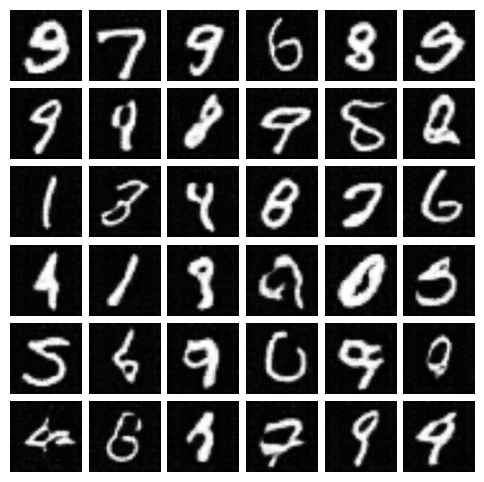

In [ ]:
plot_samples(n_samples=36, generator=generator) 

## CIFAR10

We train CIFAR10 under the same setting. The generated image is shown below.

In [ ]:
fixed_noise = torch.randn(16, 100, 1, 1).to(DEVICE)
discriminator = Discriminator(weight_init=True).to(DEVICE)
generator = Generator(weight_init=True).to(DEVICE)

In [ ]:
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(generator, discriminator, dataloader, 5, optimizerD, optimizerG)

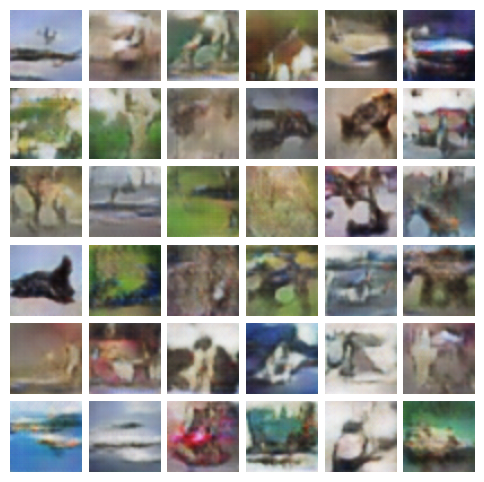

In [ ]:
plot_samples(n_samples=36, generator=generator) 

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/abs/1511.06434